In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
import numpy as np
import cv2
import glob
import pickle
%matplotlib 

Using matplotlib backend: Qt5Agg


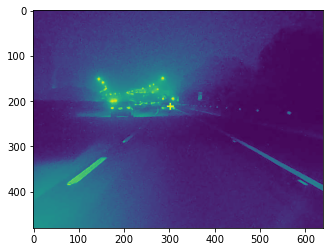

In [2]:
image = mping.imread('./test_images/test1.jpg')
plt.imshow(image)

In [82]:
def color_gradient_threshold(image_undistorted):
    ksize = 15
    # 原圖進⾏梯度（邊緣）檢測
    gradx = abs_sobel_thresh(image_undistorted, orient = 'x', sobel_kernel = ksize, thresh = (50,90))
    grady = abs_sobel_thresh(image_undistorted, orient = 'y', sobel_kernel = ksize, thresh = (30,90))
    # 原圖進⾏顏⾊閾檢測
    c_binary = image_undistorted#color_thresh(image_undistorted, s_thresh = (70,100), l_thresh = (60,255), b_thresh = (50,255), v_thresh = (150,255))
    rgb_binary = image_undistorted#rgb_select(image_undistorted, r_thresh = (225,255), g_thresh = (225,255), b_thresh = (0,255))
    combined_binary = image_undistorted#np.zeros_like(s_channel)
    # 將梯度檢測結果和顏⾊閾檢測結果進⾏組合疊加
    combined_binary[((gradx == 1) & (grady == 1) | (c_binary == 1) | (rgb_binary==1))] = 255
    # 輸出處理後的圖片
    color_binary = combined_binary
    return color_binary, combined_binary

In [50]:
def abs_sobel_thresh(image, orient = 'x', sobel_kernel = 3, thresh = (0, 255)):
    # 計算X或Y⽅向的⽅向梯度
    # 轉化成灰度圖像
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 求X或Y⽅向的⽅向梯度
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 數據重新縮放
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 創建⼀個空矩陣，⿊圖片
    grad_binary = np.zeros_like(scaled_sobel)
    # 梯度在閾值範圍內的，圖片點亮
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

In [76]:
# 使⽤hsv中的s通道，lab中的b通道，luv中的l通道，hsv中的v通道
def color_thresh(img, s_thresh, l_thresh, b_thresh, v_thresh):
    # 顏⾊閾變化，分別將RGB圖像轉化成LUV，HLS，HSV，lab圖像（分別⽤LUV，HLS，HSV，LAB
    # ⽅式來表⽰同⼀張RGB圖像）
    luv = cv2.cvtColor(image, cv2.COLOR_LRGB2LUV)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    # 提取hsv中的s通道，lab中的b通道，luv中的l通道，hsv中的v通道
    s_channel = hsv[:,:,1]
    b_channel=lab[:,:,2]
    l_channel = luv[:,:,0]
    v_channel= hsv[:,:,2]
    # 提取S通道中符合閾值的像素點
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # 提取b通道中符合閾值的像素點
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel > b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    # 提取l通道中符合閾值的像素點
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    # 提取v通道中符合閾值的像素點
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    # 提取同時滿⾜以上4個通道閾值的像素點
    combined = np.zeros_like(s_channel)
    combined[((s_binary == 1) & (b_binary == 1) & (l_binary == 1) & (v_binary == 1))] = 1
    return combined

In [52]:
# rgb通道
def rgb_select(img, r_thresh, g_thresh, b_thresh):
    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    b_channel = img[:,:,2]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    g_binary = np.zeros_like(g_channel)
    g_binary[(g_channel > g_thresh[0]) & (g_channel <= g_thresh[1])] = 1
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel > b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    combined = np.zeros_like(r_channel)
    combined[((r_binary == 1) & (g_binary == 1) & (b_binary == 1))] = 1
    return combined

In [53]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2] # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [54]:
def apply_region_of_interest_mask(image):
    x_factor = 40
    y_factor = 60
    vertices = np.array([[
    (0,image.shape[0]),
    (((image.shape[1] / 2) - x_factor), (image.shape[0] / 2)+ y_factor),
    (((image.shape[1] / 2) + x_factor), (image.shape[0] / 2)+ y_factor),
    (image.shape[1], image.shape[0])]], dtype = np.int32)
    return region_of_interest(image, vertices)

In [84]:
# 透視變換，輸入為原圖和進⾏閾值檢測後的圖
def perspective_transform(image_undistorted, combined_binary):
    # 定義原圖中待映射的4個點坐標
    top_left = [560, 470]
    top_right = [730, 470]
    bottom_right = [1080, 720]
    bottom_left = [200, 720]
    # 定義映射後的4個點的坐標
    top_left_dst = [200,0]
    top_right_dst = [1100,0]
    bottom_right_dst = [1100,720]
    bottom_left_dst = [200,720]
    img_size = (image_undistorted.shape[1], image_undistorted.shape[0])
    # 數據格式整理
    src = np.float32([top_left,top_right, bottom_right, bottom_left])
    dst = np.float32([top_left_dst, top_right_dst, bottom_right_dst, bottom_left_dst])
    # 求映射的關係矩陣
    M = cv2.getPerspectiveTransform(src, dst)
    # 輸出透視變換後的圖片
    warped = cv2.warpPerspective(combined_binary, M, img_size)
    return warped, M

In [88]:
def finding_line(warped):
    # 將warped中每⼀列從360⾏開始加到720⾏；
    histogram2 = np.sum(warped[warped.shape[0]//2:,:], axis = 0)
    out_img = np.dstack((warped, warped, warped)) * 255
    # 找到原圖的中間點
    midpoint = np.int(histogram2.shape[0] / 2)
    # 找到左側波峰出現的橫坐標，即為左側⾞道線的中⼼
    leftx_base = np.argmax(histogram2[:midpoint])
    # 找到右側波峰出現的橫坐標，即為右側⾞道線的中⼼
    rightx_base = np.argmax(histogram2[midpoint:]) + midpoint
    # 以種個⾞道線中⼼為起點，畫5個窗⼝
    nwindows = 5
    # 窗⼝⼤⼩為圖片⼤⼩5等分
    window_height = np.int(warped.shape[0] / nwindows)
    # 提取原圖中非零的像素點的坐標
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    #定義窗⼝的寬度
    margin = 100
    #定義窗⼝內最⼩有效像素點的個數
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        # 窗⼝的下邊沿
        win_y_low = warped.shape[0] - (window + 1) * window_height
        # 窗⼝的上邊沿
        win_y_high = warped.shape[0] - window * window_height
        # 左側⾞道線窗⼝的左邊沿
        win_xleft_low = leftx_current - margin
        # 左側⾞道線的右邊沿
        win_xleft_high = leftx_current + margin
        # 右側⾞道線的左右邊沿
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # 畫矩形
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high,win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high,win_y_high), (0, 255, 0), 2)
        # 非零的坐標落在矩形窗⼝內的，提取其序號
        ## 左側
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        ## 右側
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # 將這些序號儲存起來
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # 如果有效像素點的個數⼤於50，取這些像素點橫坐標的均值作為新的中⼼點
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # 數組拼接
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # 根據點擬合出⼀條⼆次曲線，輸出⼆次曲線的係數
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # 畫出⾞道線
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    # 找出左⾞道線附近的像素點序號；
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) +
    left_fit[1] * nonzeroy +
    left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) +
    left_fit[1] * nonzeroy + left_fit[2] + margin)))
    # 找出右⾞道線附近的像素點序號；
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) +
    right_fit[1] * nonzeroy +
    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
    right_fit[1] * nonzeroy + right_fit[2] + margin)))
    # 返回⼆次曲線的係數和⾞道線上的點
    return left_fitx, right_fitx,out_img, left_fit, right_fit, left_lane_inds, right_lane_inds

In [92]:
def CalculateCurvature(binary_image, left_fit, right_fit, l_lane_inds, r_lane_inds):
    img_size = (binary_image.shape[1], binary_image.shape[0])
    ploty = np.linspace(0, img_size[1]-1, img_size[1])
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # y⽅向720個像素，對應30米
    xm_per_pix = 3.7/960 # x⽅向960個像素，對應3.7米
    # 找到圖像中不為零的所有像素點的像素坐標
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])# 將這些不為零的像素點坐標分成x，y⾞道線中
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds]
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    # 將這些像素點對應到世界坐標系中，然後擬合成⼆次曲線
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # 計算曲線的曲率
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix +
    left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix +
    right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # 左右⾞道線曲率平均
    avg_curverad = (left_curverad + right_curverad) / 2
    ## 以下計算本⾞在⾞道線中⼼的位置
    dist_from_center = 0.0
    if right_fit is not None:
        if left_fit is not None:
            # 攝像頭位於圖像中間，也是本⾞的中⼼
            camera_pos = img_size[0] / 2
        # 左右⾞道線最底端x坐標
        left_lane_pix = np.polyval(left_fit, binary_image.shape[0])
        right_lane_pix = np.polyval(right_fit, binary_image.shape[0])
        # 左右⾞道線中點x坐標
        center_of_lane_pix = (left_lane_pix + right_lane_pix) / 2
        # 攝像頭（本⾞中⼼）與⾞道線中⼼的距離
        dist_from_center = (camera_pos - center_of_lane_pix) * 3.7/960
    return avg_curverad, dist_from_center, ploty

In [57]:
def overlay_text_on_image (image, avg_curverad, dist_from_center):
    new_img = np.copy(image)
    # 字體和字體顏⾊
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_color = (255,255,255)
    num_format = '{:04.2f}'
    text = 'Radius of Curvature: ' + num_format.format(avg_curverad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, font_color, 2, cv2.LINE_AA)
    direction = 'left'
    if dist_from_center > 0:
        direction = 'right'
    abs_dist = abs(dist_from_center)
    text = 'Vehicle is ' + num_format.format(abs_dist) + ' m ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, font_color, 2, cv2.LINE_AA)
    return new_img

In [100]:
def main_pipline(image_0):
    #1 畸變矯正
    image_undistorted = image
    #2 顏⾊與梯度閾
    color_binary, combined_binary = color_gradient_threshold(image)
    #3 感興趣區域
    masked = apply_region_of_interest_mask(combined_binary)
    #4 透視變換
    warped_0, Minv = perspective_transform(masked, combined_binary)
    #5 滑動窗⾞道線提取
    left_fitx, right_fitx, out_img, left_fit, right_fit, left_lane_inds, right_lane_inds = finding_line(warped_0)
    #6 計算⾞道線的曲率
    avg_curverad, dist_from_center, ploty = CalculateCurvature(warped_0, left_fit, right_fit, left_lane_inds, right_lane_inds)
    #7 在圖像上畫⾞道線
    warp_zero = np.zeros_like(warped_0).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_0.shape[1], image_0.shape[0]))
    result = newwarp#cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    #8 圖像上顯⽰文字
    result = overlay_text_on_image (result, avg_curverad, dist_from_center)
    return result

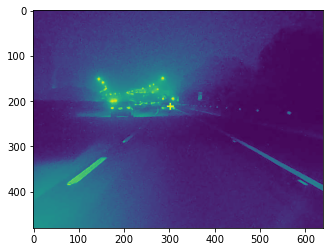

In [105]:
image = mping.imread('./test_images/test1.jpg')
plt.imshow(image)

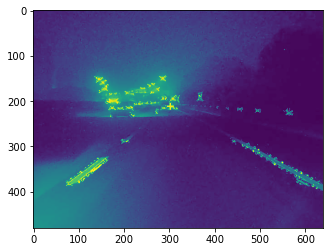

In [107]:
main_pipline(image)
plt.imshow(image)